In [4]:
from dCSFA_NMF import dCSFA_NMF
import umc_data_tools as umc_dt
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
import torch



## Loading the Data

In [5]:
DS_FEATURES = False

#Note, we are using the demo test set for the validation data in this demo. Make sure you save your test sets for final analysis in real projects.
TRAINING_DATA_FILE = "TeST_train_dict.pkl"
VALIDATION_DATA_FILE = "TeST_test_dict.pkl"

#Features used in our data construction. In this example we are using power, coherence, and granger caussality.

if not DS_FEATURES:
    X_FEATURE_LIST = ["X_psd","X_coh","X_gc"]
else:
    X_FEATURE_LIST = ["X_psd_ds","X_ds"]

#These weights allow for multiplying a given feature by a constant. For example, if power is significantly lower magnitude than other features, we can set the weight to upscale those features. 
#There are countermeasures in the model that handle this already though, so a default of 1 for every feature is usually sufficient
X_FEATURE_WEIGHTS = [1,1,1] 

#Feature for which we would like to predict. In this demo, we will need to convert these values to a binary vector. Your case may already be in a binary vector however.
Y_FEATURE = "y_task" 

#Feature for which you would like to make an intercept for each unique value. Typically this is done per mouse.
Y_INTERCEPT_FEATURE = "y_mouse" 

#Y_SAMPLING_FEATURE can be used to ensure equal use in the model for different groups. If "y_mosue" is used, then each mouse will have equal influence on the model, regardless of recording length.
Y_SAMPLING_FEATURE = "y_mouse" 


In [6]:
#Loading the training data
with open(TRAINING_DATA_FILE,"rb") as f:
    train_dict = pickle.load(f)

print("Dictionary Keys: ",train_dict.keys())
#Loading the validation data
with open(VALIDATION_DATA_FILE,"rb") as f:
    val_dict = pickle.load(f)

#Create X matrices
X_train = np.hstack([train_dict[feature]*weight for feature,weight in zip(X_FEATURE_LIST,X_FEATURE_WEIGHTS)])
X_val = np.hstack([val_dict[feature]*weight for feature,weight in zip(X_FEATURE_LIST,X_FEATURE_WEIGHTS)])

#Create y vectors for prediction. In this case we wish to predict for the Tail-Suspension (TS) condition and convert our label vector to {1: TS, 0: other}.
y_train = (train_dict[Y_FEATURE]=="TS").reshape(-1,1)
y_val = (val_dict[Y_FEATURE]=="TS").reshape(-1,1)

#Create intercept and sampling vectors (note, these vectors are only relevant to training)
y_intercept_train = train_dict[Y_INTERCEPT_FEATURE]
y_sampling_train = OrdinalEncoder().fit_transform(train_dict[Y_SAMPLING_FEATURE].reshape(-1,1))
y_intercept_mask = OneHotEncoder().fit_transform(y_intercept_train.reshape(-1,1)).todense()

Dictionary Keys:  dict_keys(['X_psd', 'X_coh', 'X_gc', 'X_psd_ds', 'X_ds', 'y_mouse', 'y_task', 'y_geno', 'Freqs', 'powFeatures', 'cohFeatures', 'gcFeatures', 'dsFeatures', 'areas'])


In [25]:
train_dict.keys()

dict_keys(['X_psd', 'X_coh', 'X_gc', 'X_psd_ds', 'X_ds', 'y_mouse', 'y_task', 'y_geno', 'Freqs', 'powFeatures', 'cohFeatures', 'gcFeatures', 'dsFeatures', 'areas'])

In [33]:
train_dict["dsFeatures"]

array(['Acb_Core->Acb_Sh 1', 'Acb_Core->Acb_Sh 2', 'Acb_Core->Acb_Sh 3',
       ..., 'mSNC->mDHip 54', 'mSNC->mDHip 55', 'mSNC->mDHip 56'],
      dtype='<U21')

In [27]:
train_dict["X_psd"].shape

(786, 616)

In [28]:
train_dict["X_coh"].shape

(786, 3080)

In [29]:
train_dict["X_gc"].shape

(786, 6160)

In [30]:
train_dict["Freqs"]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56], dtype=int32)

In [31]:
train_dict["powFeatures"]

array(['Acb_Core 1', 'Acb_Core 2', 'Acb_Core 3', 'Acb_Core 4',
       'Acb_Core 5', 'Acb_Core 6', 'Acb_Core 7', 'Acb_Core 8',
       'Acb_Core 9', 'Acb_Core 10', 'Acb_Core 11', 'Acb_Core 12',
       'Acb_Core 13', 'Acb_Core 14', 'Acb_Core 15', 'Acb_Core 16',
       'Acb_Core 17', 'Acb_Core 18', 'Acb_Core 19', 'Acb_Core 20',
       'Acb_Core 21', 'Acb_Core 22', 'Acb_Core 23', 'Acb_Core 24',
       'Acb_Core 25', 'Acb_Core 26', 'Acb_Core 27', 'Acb_Core 28',
       'Acb_Core 29', 'Acb_Core 30', 'Acb_Core 31', 'Acb_Core 32',
       'Acb_Core 33', 'Acb_Core 34', 'Acb_Core 35', 'Acb_Core 36',
       'Acb_Core 37', 'Acb_Core 38', 'Acb_Core 39', 'Acb_Core 40',
       'Acb_Core 41', 'Acb_Core 42', 'Acb_Core 43', 'Acb_Core 44',
       'Acb_Core 45', 'Acb_Core 46', 'Acb_Core 47', 'Acb_Core 48',
       'Acb_Core 49', 'Acb_Core 50', 'Acb_Core 51', 'Acb_Core 52',
       'Acb_Core 53', 'Acb_Core 54', 'Acb_Core 55', 'Acb_Core 56',
       'Acb_Sh 1', 'Acb_Sh 2', 'Acb_Sh 3', 'Acb_Sh 4', 'Acb_Sh 5',
    

In [35]:
train_dict["y_mouse"].shape

(786,)

In [36]:
train_dict["y_mouse"]

array(['MouseCKV10', 'MouseCKV10', 'MouseCKV10', 'MouseCKV10',
       'MouseCKV10', 'MouseCKV10', 'MouseCKV10', 'MouseCKV10',
       'MouseCKV10', 'MouseCKV10', 'MouseCKV10', 'MouseCKV10',
       'MouseCKV10', 'MouseCKV10', 'MouseCKV10', 'MouseCKV10',
       'MouseCKV10', 'MouseCKV10', 'MouseCKV10', 'MouseCKV10',
       'MouseCKV10', 'MouseCKV10', 'MouseCKV10', 'MouseCKV10',
       'MouseCKV10', 'MouseCKV10', 'MouseCKV10', 'MouseCKV10',
       'MouseCKV10', 'MouseCKV10', 'MouseCKV10', 'MouseCKV10',
       'MouseCKV10', 'MouseCKV10', 'MouseCKV10', 'MouseCKV10',
       'MouseCKV10', 'MouseCKV10', 'MouseCKV10', 'MouseCKV10',
       'MouseCKB9', 'MouseCKB9', 'MouseCKB9', 'MouseCKB9', 'MouseCKB9',
       'MouseCKB9', 'MouseCKB9', 'MouseCKB9', 'MouseCKB9', 'MouseCKB9',
       'MouseCKB9', 'MouseCKB9', 'MouseCKB9', 'MouseCKB9', 'MouseCKB9',
       'MouseCKB9', 'MouseCKB9', 'MouseCKB9', 'MouseCKB9', 'MouseCKB9',
       'MouseCKB9', 'MouseCKB9', 'MouseCKB9', 'MouseCKB9', 'MouseCKB9',
       'Mo

In [32]:
train_dict["powFeatures"].shape

(616,)

## Visualizing Our Data

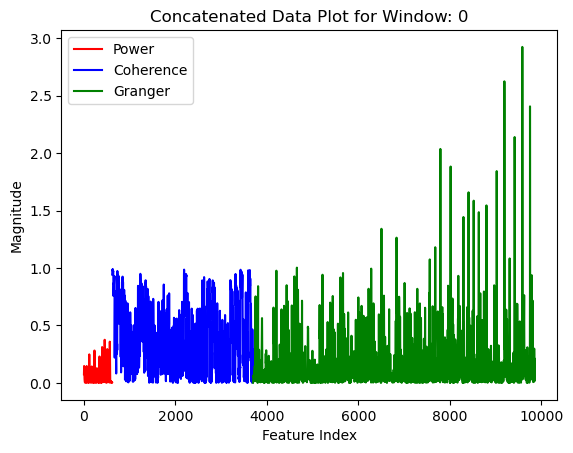

In [7]:
#I often find it helpful to look at a few individual windows

if not DS_FEATURES:
        num_power_features = len(train_dict['powFeatures'])
        num_coh_features = len(train_dict['cohFeatures'])
        num_gc_features = len(train_dict['gcFeatures'])
        window = 0
        plt.plot(range(num_power_features),train_dict['X_psd'][window,:],c='red',label='Power')
        plt.plot(range(num_power_features,num_coh_features+num_power_features),train_dict['X_coh'][window,:],c='blue',label='Coherence')
        plt.plot(range(num_coh_features+num_power_features,num_coh_features+num_power_features+num_gc_features),
                train_dict['X_gc'][window,:],c='green',label='Granger')
        plt.xlabel('Feature Index')
        plt.ylabel('Magnitude')
        plt.title("Concatenated Data Plot for Window: {}".format(window))
        plt.legend()
        plt.show()
else:
        num_power_features = len(train_dict['powFeatures'])
        num_ds_features = len(train_dict['dsFeatures'])
        window = 0
        plt.plot(range(num_power_features),train_dict['X_psd_ds'][window,:],c="red",label="Power")
        plt.plot(range(num_power_features,num_power_features+num_ds_features),train_dict['X_ds'][window,:],c="green",label="Directed Spectrum")
        plt.xlabel('Feature Index')
        plt.ylabel('Magnitude')
        plt.title("Concatenated Data Plot for Window: {}".format(window))
        plt.legend()
        plt.show()

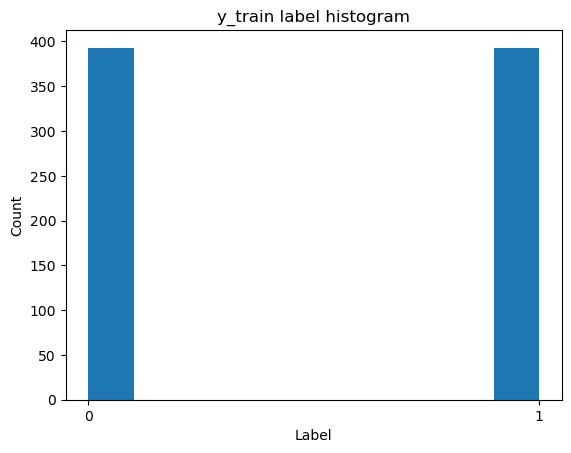

In [8]:
#It is also often helpful to know the percentage of your data that is in the positive and negative class
plt.hist(y_train.astype(int))
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('y_train label histogram')
plt.xticks(range(2),labels=['0','1'])
plt.show()

## Define the Model

In [9]:
#Save file for the model and state_dictionary for in-progress training
MODEL_SAVE_FILE = "demo_model.pt"
MODEL_STATE_DICT = "demo_sd.pt"

#Number of networks you would like to learn
N_COMPONENTS = 20

#The shape of the data used for the encoder and decoder
DIM_IN = X_train.shape[1]

#Constrains the supervised network to a certain correlation. In the case of multiple supervised networks
#Input a list of network constraints such as ['Positive','Negative']. None is also acceptable if there is
#no preference for learned correlation.
NETWORK_CONSTRAINT = "Positive"

#Device that should be used (cpu or cuda:#). "auto" detects whether a gpu is present and selects it if
#available. Auto is not recommended for multiple GPU systems. 
DEVICE = "auto"

#The number of intercepts the model should learn for the logistic regression classifier
N_INTERCEPTS = y_intercept_mask.shape[1]

#Optimization algorithm used. AdamW tends to get better predictive performance whereas SGD helps with
#providing a smooth interpretation.
OPTIMIZER = "SGD"

#only relevant if the optimizer is SGD. Helps encourage a smoother supervised network
MOMENTUM = 0.9

#The number of supervised networks you would like to train. In the case of more than 1, you must input
#y_train as a list of y vectors for each task you would like to supervise
N_SUP_NETWORKS = 1

#What type of reconstruction loss that will be used. MSE is what was used on previous cpne publications
#however, it can be sensitive to outliers. "IS" or itakura-saito divergence loss is scale invariant and
#can result in better results, but can be sensitive if the reconstruction values are close to 0.
RECON_LOSS = "MSE"

#Weighs the importance of reconstruction. Raise if reconstruction is poor.
SUP_RECON_WEIGHT = 1

#Weighs the importance of supervision. Lower if reconstruction is poor.
SUP_WEIGHT = 1

#Identifies whether we would like to use a neural network encoder or a linear encoder.
DEEP_ENC = True

#The breadth of the neural network encoder
H = 256

#This determines what type of supervised reconstruction loss is used. Residual is the default and is less
#strict than "All", however it can be prone to more sparse supervised networks. "All" can be too strict
#and result in supervised networks that try to represent all of the features rather than just those 
#relevant to the task of interest
SUP_RECON = "Residual"

#used with the residual supervised recon loss. Higher values discourage sparse supervised networks, but may result
#in poorer predictive performance.
SUP_SMOOTHNESS_WEIGHT = 1


#Feature groups provides the indices for each of the features used in the model. The model uses these
#indices to weigh the importance of reconstructing each feature. This means that the power features will
#still be important to the reconstruction, even though they only make up a small fraction of the features
running_idx = 0
feature_groups = []
for idx,feature in enumerate(X_FEATURE_LIST):
    f_begin = running_idx
    f_end = f_begin + train_dict[feature].shape[1] 
    if idx == 0:
        f_end = f_end -1
    feature_groups.append((f_begin,f_end))

    running_idx = f_end

FEATURE_GROUPS = feature_groups

#The weighting per group is calculated automatically if using None which will scale based on number of features. However,
#custom weighting may be chosen by hand. This vector should be the same length as X_FEATURE_LIST with a weight for each of
#the features
GROUP_WEIGHTS = None

In [10]:
#Define the model

#----------------------------------------------------------
# W A R N I N G
#
# The hyperparameters here and above are meant only to demonstrate usage for the model and are in no way the recommended defaults
# for training your model.
#----------------------------------------------------------

model = dCSFA_NMF(n_components=N_COMPONENTS, #Number of learned networks
                dim_in=DIM_IN, #Number of features in X
                n_sup_networks=N_SUP_NETWORKS, #Number of networks to be supervised
                optim_name=OPTIMIZER, #What type of optimizer you would like to use {SGD,Adam,AdamW}
                recon_loss=RECON_LOSS, #What type of reconstruction loss to use {MSE,IS}
                sup_recon_weight=SUP_RECON_WEIGHT, #Importance of the supervised network reconstruction
                sup_weight=SUP_WEIGHT, #Importance of the supervision weight
                n_intercepts=N_INTERCEPTS, #Number of random intercepts (often grouped by mouse, experiment, etc.)
                useDeepEnc=DEEP_ENC, #Whether or not you would like to use the deep neural network encoder
                h=H, #The breadth of the neural network encoder
                sup_recon_type=SUP_RECON, #What type of supervised reconstruction loss you would like to use {Residual,All}
                feature_groups=FEATURE_GROUPS, #Breakpoints for each type of feature i.e. power, coh, granger. Used for equivalent feature weighting
                group_weights=GROUP_WEIGHTS, #Weights for each of the groups
                fixed_corr=NETWORK_CONSTRAINT, #Correlation constraints for the supervised networks
                momentum=MOMENTUM, #Momentum value for SGD with momentum - default is 0.9
                sup_smoothness_weight=SUP_SMOOTHNESS_WEIGHT #Parameter to encourage more smooth supervised networks if using the residual reconstruction
                )

## Fit the Model

In [11]:
#Fit or Load the model
LOAD = False

if LOAD:
    #Load the model onto the cpu
    model = torch.load(MODEL_SAVE_FILE,map_location='cpu')
    model.device='cpu'
else:
    #----------------------------------------------------------
    # W A R N I N G
    #
    # The hyperparameters here and above are meant only to demonstrate usage for the model and are in no way the recommended defaults
    # for training your model.
    #
    #
    # Also, please note that the recon loss reported during training is not the same as the MSE. This is reporting the weighted reconstruction
    # of the features. Also, AUCs are by-window so you should not expect them to match the by mouse auc that we collect later.
    #----------------------------------------------------------
    model.fit(X_train,
            y_train,
            y_sample_groups=y_sampling_train, 
            y_pred_weights=None,##Weights for the importance of each window for prediction. 
                                #If `None` then all windows are weighted equally, see multiple network demo for usage
            intercept_mask=y_intercept_mask,
            task_mask=None, #Allows for masking which windows you would like to use with supervision
                            #See multiple network demo for usage
            n_epochs=1000, #Training time
            n_pre_epochs=100, #Pre-training time
            nmf_max_iter=500, #Maximum iterations for fitting unsupervised NMF for pretraining
            batch_size=128, #Batch size for gradient descent
            lr=1e-3, #Learning rate for gradient descent
            pretrain=True, #Indicates whether you would like to pretrain the model
            verbose=True, #Indicates you would like progress printouts during training
            X_val=X_val, #Validation data for early stopping (save the model with the best validation performance)
            y_val=y_val, #Validation labels for early stopping
            y_pred_weights_val=None, #same as above.
            task_mask_val=None, #Allows for masking which windows you would like to use with supervision
                                #See multiple network demo for usage
            best_model_name = MODEL_STATE_DICT #saved state of the model during training so best model can be reloaded
            )

    #Save the model
    torch.save(model,MODEL_SAVE_FILE)

Pretraining....
Pretraining NMF...
Identifying predictive components for network 0


100%|██████████| 20/20 [00:00<00:00, 1385.72it/s]

Selecting network: 11 with auc 0.7124358202383958 for sup net 0 using constraint positive correlation



Pretrain Epoch: 99, Recon Loss: 3.06: 100%|██████████| 100/100 [00:02<00:00, 48.40it/s]


Pretraining Complete
Beginning Training


Epoch: 999, Best Epoch: 999 Best Val Recon: 0.29982906579971313, Best Val by Window ROC-AUC: [0.7904437456324249] loss: 7.855897903442383, recon: 0.051257479935884476, pred by Window roc-auc: [0.5652545500456461]: 100%|██████████| 1000/1000 [00:50<00:00, 19.67it/s]


Loading best model...
Done!


## Evaluate Model Training and Performance

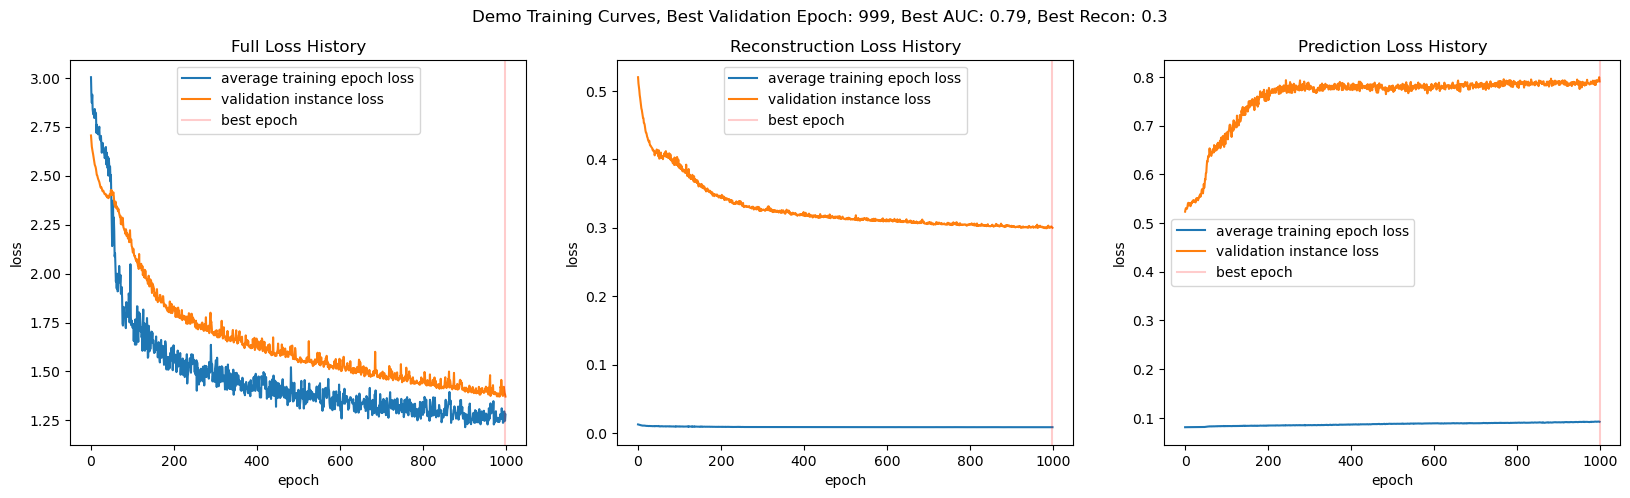

In [12]:
#The training losses are the sum losses over each training epoch. To make them comparable we get the average iteration loss for each epoch by dividing the
#training loss by a batch average factor which is approximately the number of training steps in an epoch.
BATCH_AVERAGE_FACTOR = X_train.shape[0]/128
BEST_EPOCH = model.best_epoch
BEST_AUC = model.best_val_auc[0]
BEST_VAL_RECON = model.best_val_recon.cpu().detach().numpy()
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(np.array(model.training_hist) / BATCH_AVERAGE_FACTOR,label='average training epoch loss')
plt.plot(model.val_loss_hist,label='validation instance loss')
plt.axvline(BEST_EPOCH,color='red',alpha=0.2,label='best epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Full Loss History')
plt.legend()


plt.subplot(1,3,2)
#val_recon_hist = [value.cpu().detach().numpy() for value in model.val_recon_loss_hist]
plt.plot(np.array(model.recon_hist) / BATCH_AVERAGE_FACTOR,label='average training epoch loss')
plt.plot(model.val_recon_loss_hist,label='validation instance loss')
plt.axvline(BEST_EPOCH,color='red',alpha=0.2,label='best epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Reconstruction Loss History')
plt.legend()


plt.subplot(1,3,3)
plt.plot(np.array(model.pred_hist) / BATCH_AVERAGE_FACTOR,label='average training epoch loss')
plt.plot(model.val_pred_loss_hist,label='validation instance loss')
plt.axvline(BEST_EPOCH,color='red',alpha=0.2,label='best epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Prediction Loss History')
plt.legend()

plt.suptitle("Demo Training Curves, Best Validation Epoch: {}, Best AUC: {:.3}, Best Recon: {:.3}".format(BEST_EPOCH,BEST_AUC,BEST_VAL_RECON))
plt.show()

## Evaluating Reconstruction Contribution of the Supervised Network

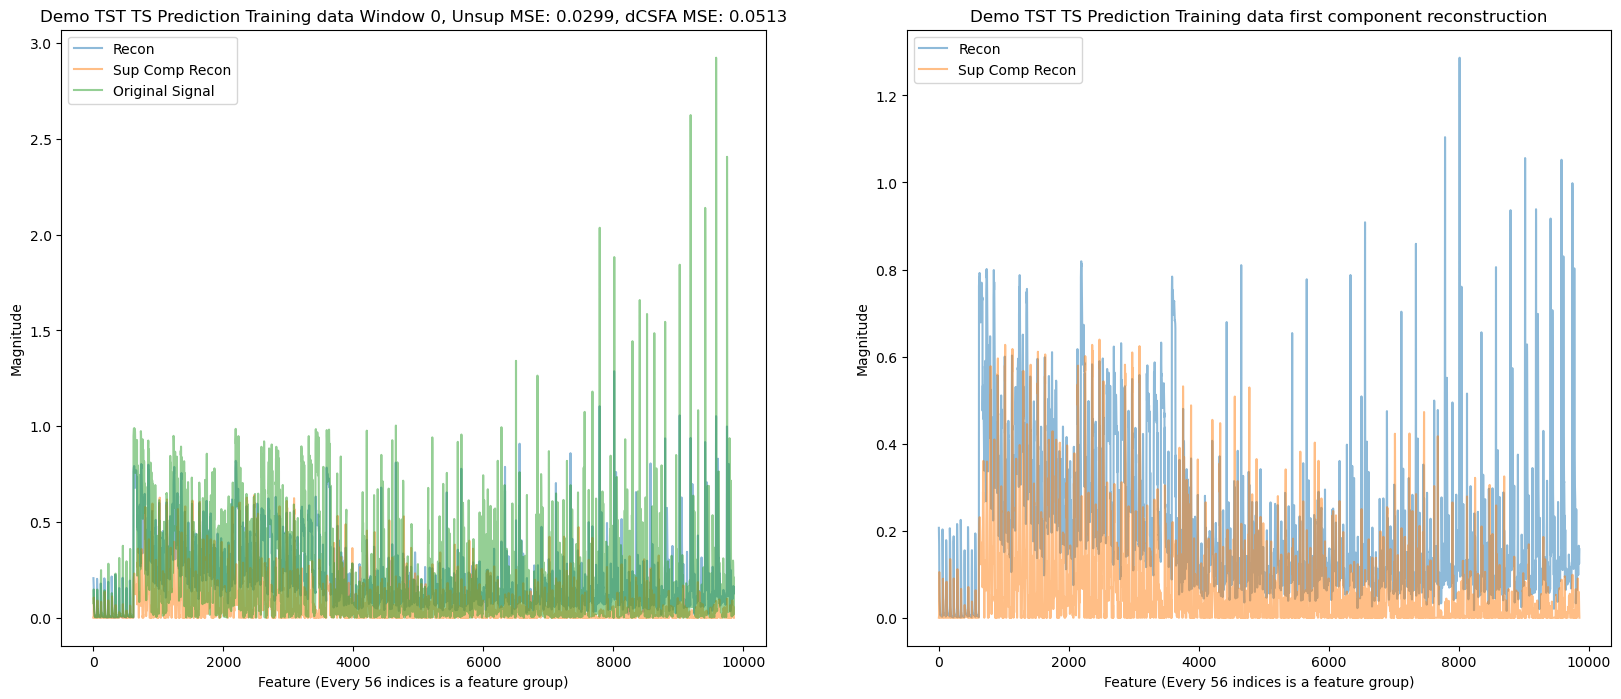

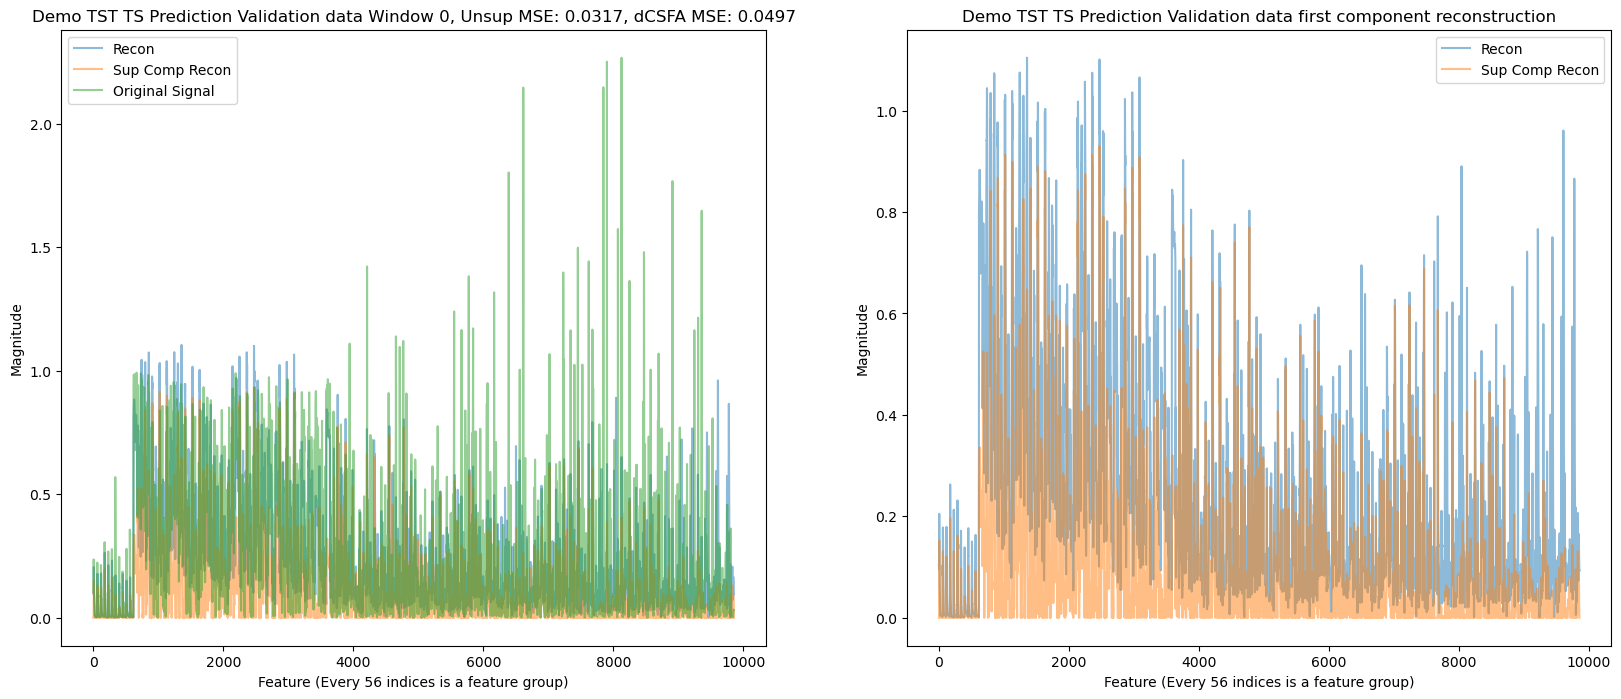

In [13]:
#These plots show the first component reconstructions and complete reconstructions for a single window. The MSE for all windows is shown in the title.
umc_dt.make_recon_plots(model,X_train,0,task="Demo TST TS Prediction Training",saveFile="Demo_train_recon_plot.png")
umc_dt.make_recon_plots(model,X_val,0,task="Demo TST TS Prediction Validation",saveFile="Demo_val_recon_plot.png")

In [14]:
#It is often helpful to compare the MSE to the Variance of the data to infer how much true trend is caputered. If the ratio is greater than 1 that is very bad.
val_mse = model.get_mse_score(X_val)
train_mse = model.get_mse_score(X_train)

var_train = np.std(X_train)**2
var_val = np.std(X_val)**2
print("Training MSE: {:.2}, Training Var: {:.2}, Ratio: {:.2}".format(train_mse,var_train,train_mse/var_train))
print("Validation MSE: {:.2}, Validation Var: {:.2}, Ratio: {:.2}".format(val_mse,var_val,val_mse/var_val))

Training MSE: 0.051, Training Var: 0.076, Ratio: 0.67
Validation MSE: 0.05, Validation Var: 0.074, Ratio: 0.68


(20, 616) (20, 3080) (20, 6160)


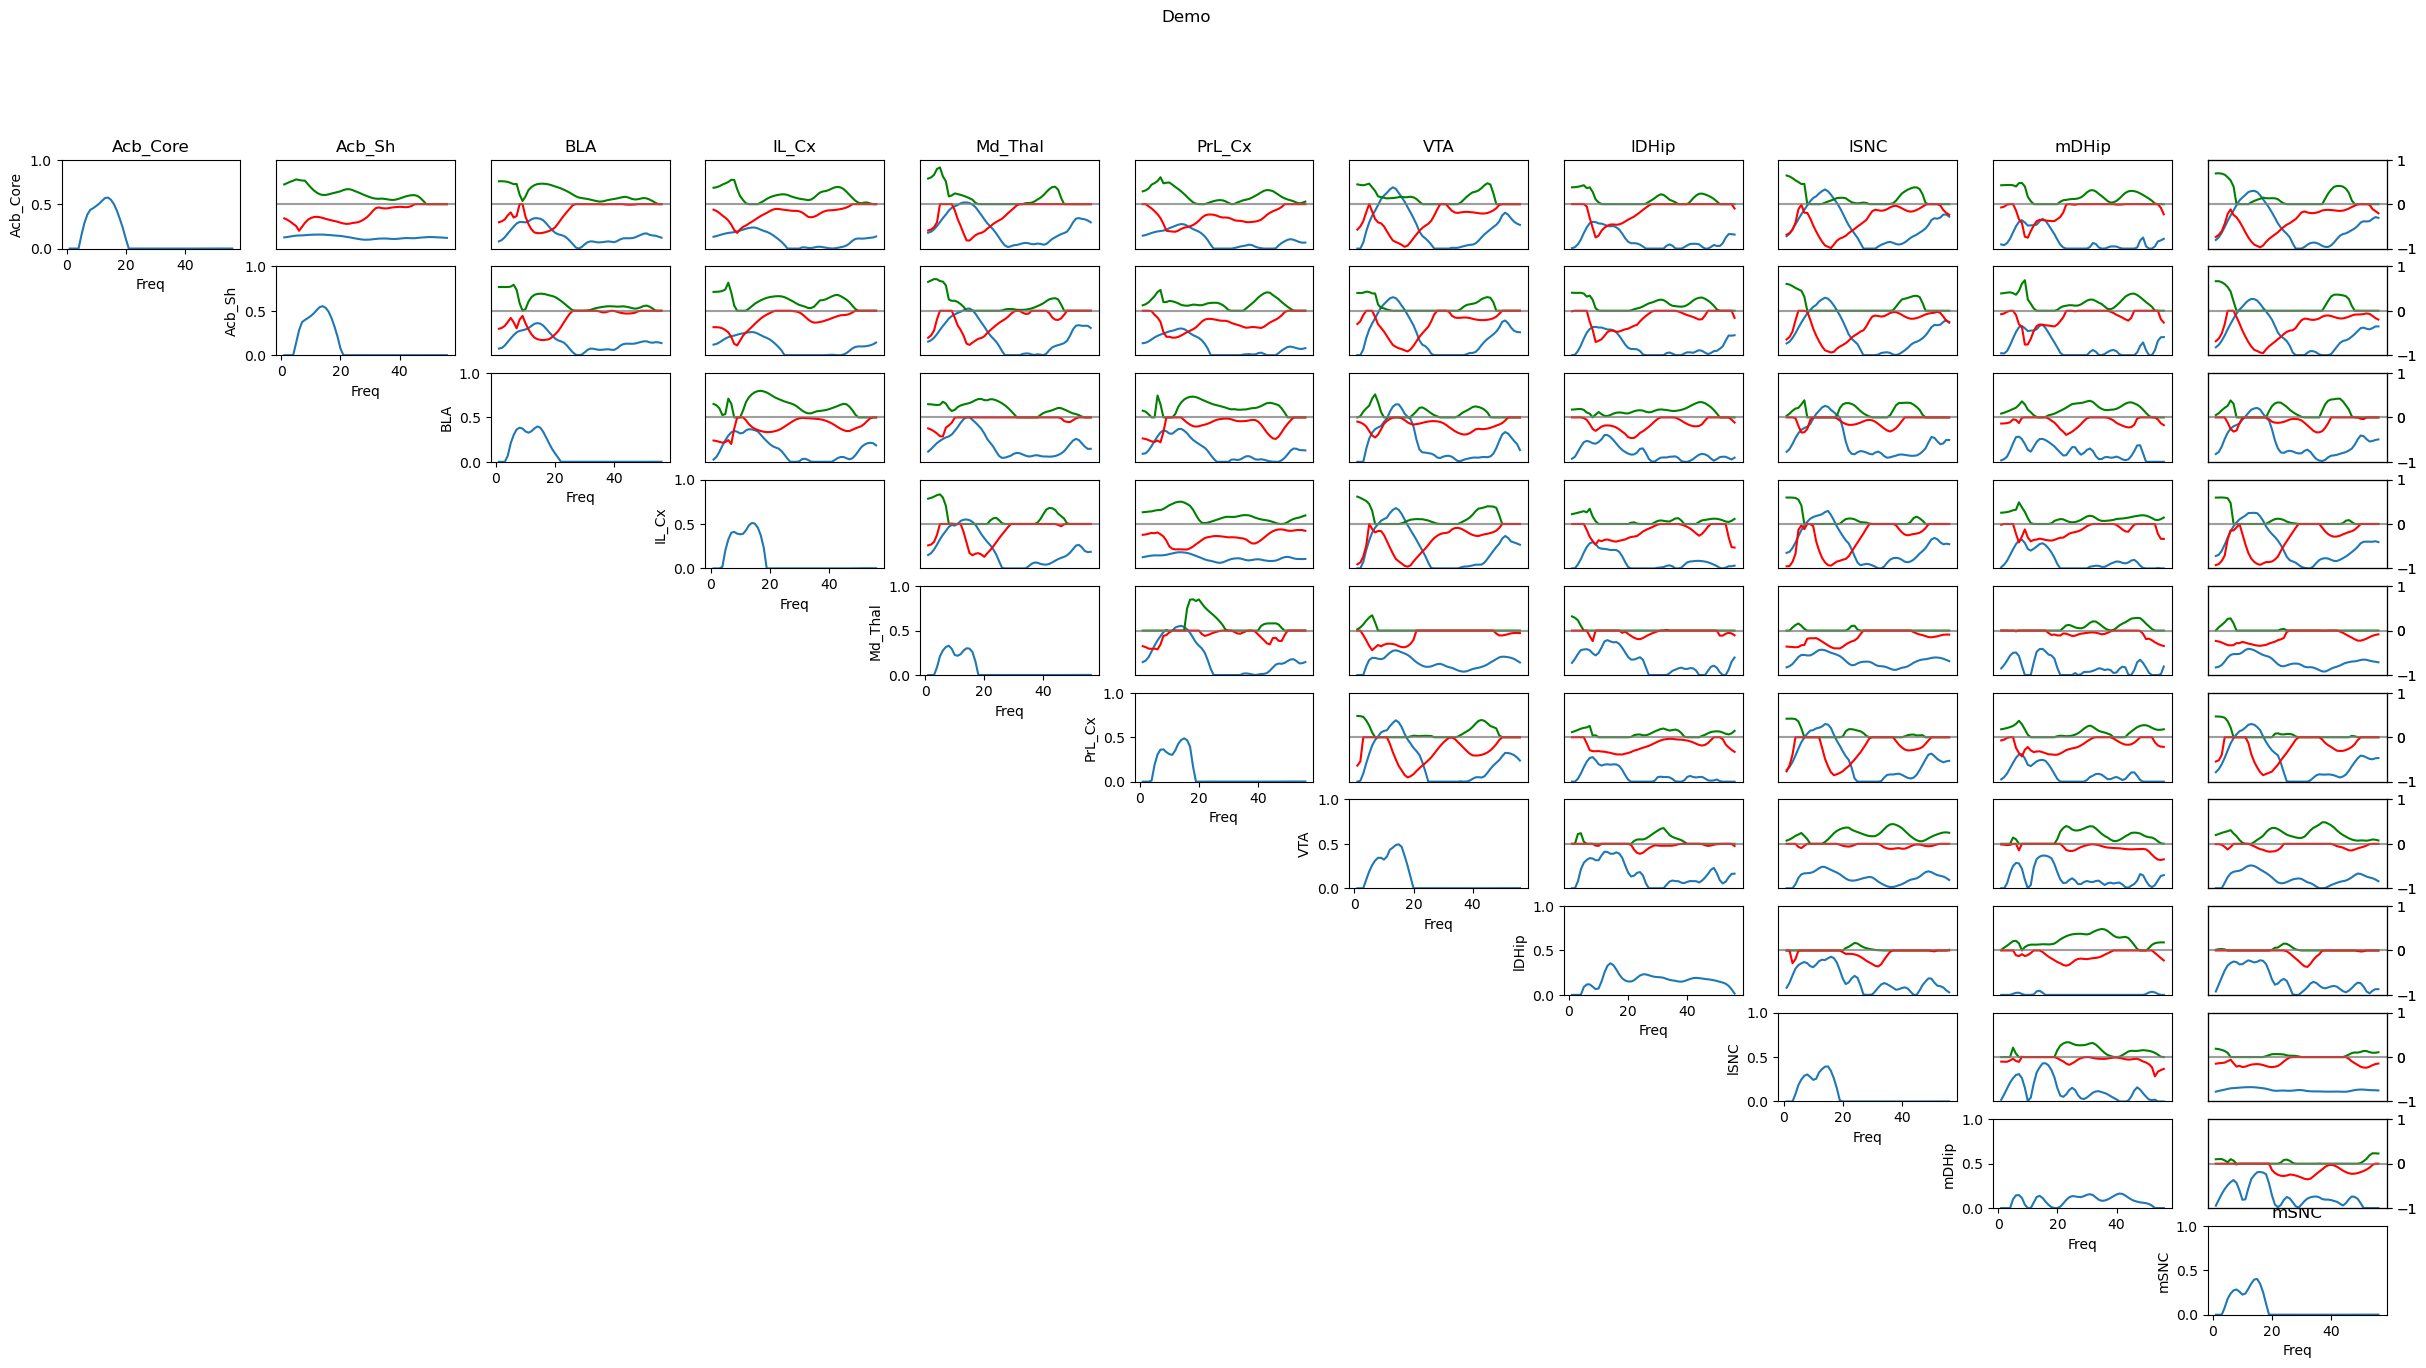

In [15]:
#We also want to evaluate how much our supervised network contributes to the reconstruction of each feature. This allows us to gauge the influence
#our network has on overall brain activity. Green and Red indicate directionality. Green is directionality from the row to the column and red
#is the directionality from the column area to the row area. Red directionality is flipped for visibility and is marked using the far right axis
#of all plots that ranges from -1 to 1. -1 indicates 100% contribution for red and 1 indicats 100% contribution for green. 
#Shapes of the power coherence and granger network contributions are printed out before plotting as a debugging tool.

#Returns a K x M matrix where K is the number of networks learned and M is the number of features. Each entry shows the kth networks percent
#contribution for reconstruction feature m. If you sum this matrix along K, you should end up with a vector of approximately 1's.
perc_contribution = umc_dt.getReconContribution(X_val,N_COMPONENTS,model)

if not DS_FEATURES:
    #Generate the plot
    umc_dt.makeUpperTriangularPlot_pow_coh_gc(perc_contribution, #matrix retrieved above
                                                areas=train_dict['areas'], #all areas recorded
                                                psdFeatures=train_dict['powFeatures'], #powerfeatures
                                                cohFeatures=train_dict['cohFeatures'], #coherence features of format Area1-Area2 <Freq #>
                                                gcFeatures=train_dict['gcFeatures'], #gc features of format Area1->Area2 <Freq #>
                                                freq=56, #number of frequencies per feature
                                                net_idx=0, #which network you would like to generate a plot for. Supervised networks are typically 0
                                                saveFile='UT_demo.png', #saveFile name
                                                title="Demo", #Title for your plot
                                                figsize=(30,15), #size of the plot (width, height)
                                                silenceTicks=True #whether you would like to include the left y-axis labels and x-axis labels on every subplot
                                                )

else:
    umc_dt.makeUpperTriangularPlot_pow_ds(perc_contribution, #matrix retrieved above
                                                areas=train_dict['areas'], #all areas recorded
                                                psdFeatures=train_dict['powFeatures'], #powerfeatures
                                                dsFeatures=train_dict['dsFeatures'], #gc features of format Area1->Area2 <Freq #>
                                                freq=56, #number of frequencies per feature
                                                net_idx=0, #which network you would like to generate a plot for. Supervised networks are typically 0
                                                saveFile='UT_demo.png', #saveFile name
                                                title="Demo", #Title for your plot
                                                figsize=(30,15), #size of the plot (width, height)
                                                silenceTicks=True #whether you would like to include the left y-axis labels and x-axis labels on every subplot
                                                )

## Evaluating Model Predictive Performance

In [16]:
#It is frequently of interest to evaluate the by mouse AUC. This is different than by window as we calculate the AUC for
#each mouse and then take the average and standard error of all mice. We support evaluating the AUC using both the ROC-AUC
#and Mann-Whitney-U methods. These methods should produce identical results in the case of a positively constrained network.
#if the network is negatively correlated, then the deviation from .5 should be the same. For example a negatively correlated
#network with a roc-auc of .9 should have a mw auc of .1.
y_pred_proba, s = model.predict_proba(X_train,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred_proba,y_train.squeeze(),train_dict['y_mouse'])
print("train by-mouse roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred_proba,y_train.squeeze(),train_dict['y_mouse'],s,True)
print("train by-mouse mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

y_pred_proba, s = model.predict_proba(X_val,include_scores=True)
roc_mean,roc_std = umc_dt.get_mean_std_err_auc(y_pred_proba,y_val.squeeze(),val_dict['y_mouse'])
print("Val by-mouse roc auc mean: %0.2f +/- %0.2f"%(roc_mean,roc_std))
mw_mean,mw_std = umc_dt.get_mean_std_err_auc(y_pred_proba,y_val.squeeze(),val_dict['y_mouse'],s,True)
print("Val by-mouse mw auc mean: %0.2f +/- %0.2f"%(mw_mean,mw_std))

train by-mouse roc auc mean: 0.83 +/- 0.02
train by-mouse mw auc mean: 0.83 +/- 0.02
Val by-mouse roc auc mean: 0.82 +/- 0.06
Val by-mouse mw auc mean: 0.82 +/- 0.06


## Projections

In [17]:
#These are features from the specified projection data file that you would like included in the csv. They must be features
#that have an entry for each window
INCLUDED_FEATURES = ["y_mouse","y_task","y_geno"]

#The file you would like to save to
PROJECTION_SAVE_FILE = "demo_val_projection.csv"

#Get the auc for each mouse. Typically we want the mann-whitney auc so we can infer correlation with the task
y_pred_proba, s = model.predict(X_val,include_scores=True)
mw_auc_dict = umc_dt.lpne_auc(y_pred_proba,y_val.squeeze(),val_dict['y_mouse'],s,True)

#Make the projection. This also returns a pandas dataframe so you can check that the csv has the information you need right here
#in the same python environment.
projection_df = umc_dt.make_projection_csv(VALIDATION_DATA_FILE, #Pickle file you'd like to use for projection
                                            model, #Learned dCSFA-NMF model
                                            X_FEATURE_LIST, #Features used to construct X
                                            INCLUDED_FEATURES, #Features you'd like included in the csv
                                            PROJECTION_SAVE_FILE, #Save file for the csv
                                            auc_dict=mw_auc_dict, #by mouse auc dictionary
                                            auc_type="mw", #What type of auc calculation is being used
                                            weights=X_FEATURE_WEIGHTS) #Weights for each feature for construction X

projection_df.head()

,scores,y_mouse,y_task,y_geno,auc,p_val
0,0.112340,MouseCKO3,TS,False,0.986264,7.617191e-07
1,0.016528,MouseCKO3,OF,False,0.986264,7.617191e-07
2,0.035735,MouseCKO3,TS,False,0.986264,7.617191e-07
3,0.089348,MouseCKO3,TS,False,0.986264,7.617191e-07
4,0.078724,MouseCKO3,TS,False,0.986264,7.617191e-07


## Save your workbook as an HTML file for easy sharing with coworkers

In [19]:
raise ValueError()

ValueError: 

In [21]:
X_train.shape

(786, 9856)

In [23]:
num_power_features

616

import os

#install ipylab with `pip install ipylab`
from ipylab import JupyterFrontEnd

NOTEBOOK_NAME = "dCSFA_NMF_demo.ipynb" #Change this to the name of your notebook


app = JupyterFrontEnd()
app.commands.execute('docmanager:save')
os.system('jupyter nbconvert --to html {}'.format(NOTEBOOK_NAME))